In [2]:
# Initializations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

%config InlineBackend.figure_formats = ['svg']

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'mathtext.fontset': 'cm'})
mpl.rcParams.update({'font.family':'serif'})
mpl.rcParams.update({'font.serif':'STIXGeneral'})

mpl.rcParams.update({'axes.titlesize': 20})
mpl.rcParams.update({'axes.labelsize': 24})
mpl.rcParams.update({'axes.linewidth': 0.5})
mpl.rcParams.update({'xtick.labelsize': 16})
mpl.rcParams.update({'ytick.labelsize': 16})
mpl.rcParams.update({'legend.framealpha': 1})
mpl.rcParams.update({'axes.titlepad': 12})
mpl.rcParams.update({'figure.dpi': 100})

## Simulation parameters

In [5]:
import numpy as np

# Physical Parameters___________________________
g = 9.81
D_eq = 0.001
mu = 0.001
rho = 1000
Re = 150
phi = 0.4

AR = 1
L = 15
L_x, L_y, L_z = L, L, AR * L
N = (phi * L_x * L_y * L_z) / (np.pi / 6)

# Numerical Parameters_____________________________
mpd = 48
delta_x = D_eq / mpd
t_end = 100
CFL = 0.3

n_cells = (L_x * L_y * L_z * mpd**3)
n_procs = n_cells / 550e3

#output parameters_______________________________
u_c = (Re * mu) / (rho * D_eq)
t_c = D_eq / u_c

delta_t = (1 / 500) * t_c
delta_t_max = (CFL * delta_x) / (3 * u_c / (1 - phi))
t_end_dim = t_end * t_c
days = (t_end_dim / delta_t_max) / 6000 # iterations/day on cedar

# Printing the results___________________________
print(
    f'\
    Re \t= {Re:}\n\
    N \t= {int(N):}\n\
    \n\
    u_c \t= {u_c:g}\n\
    t_c \t= {t_c:g}\n\
    (1/200)t_c \t= {delta_t:.2e}\n\
    delta_t_max\t= {delta_t_max:.2e}\n\
    t_end_dim \t= {t_end_dim:g}s\
    \n\n\
    n_procs \t= {int(n_procs):}\n\
    days \t= {days:.1f}'
    )

    Re 	= 150
    N 	= 2578
    
    u_c 	= 0.15
    t_c 	= 0.00666667
    (1/200)t_c 	= 1.33e-05
    delta_t_max	= 8.33e-06
    t_end_dim 	= 0.666667s    

    n_procs 	= 678
    days 	= 13.3


## Regression plot function

In [3]:
def plot_regression(D_in, D_pred, coord=None, title=None, save_fig=False):
    
    
    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16
    plt.rcParams['axes.labelsize'] = 22
    plt.rcParams['axes.titlesize'] = 14

    # generate the best fit for the predicted data ___________________
    lim1 = np.mean(D_in) - 3.5*np.std(D_in)
    lim2 = np.mean(D_in) + 3.5*np.std(D_in)
    lim3 = np.mean(D_pred) - 2*np.std(D_pred)

    reg2 = LinearRegression()
    reg2.fit(D_in.reshape(-1,1), D_pred.reshape(-1,1))
    D_vec = np.linspace(lim1, lim2, 100).reshape(-1,1)
    D_reg2 = reg2.predict(D_vec)
    
    # Plots _____________________
    fig, ax1 = plt.subplots(figsize=(4,4), tight_layout=True)
    
    ax1.scatter(D_in, D_pred,
                marker='o',
                s=10, linewidth=0.4,
                alpha=0.5,
                edgecolor='black', facecolor='white')
    ax1.plot([lim1, lim2], [lim1, lim2], linestyle='-', color='red', linewidth=2.5, alpha=0.3)
#     ax1.plot(D_vec, D_reg2, linestyle='-', color='black', linewidth=2.5, alpha=0.1)
    
    ax1.set_aspect('equal')
    
    if coord != None:
        if coord == 'F_x':
            ax1.set_xlabel('$\Delta F_{x,DNS}$', labelpad=15)
            ax1.set_ylabel('$\Delta F_{x,MPP}$', labelpad=10)
        elif coord == 'F_y':
            ax1.set_xlabel('$\Delta F_{y,DNS}$', labelpad=15)
            ax1.set_ylabel('$\Delta F_{y,MPP}$', labelpad=10)
        elif coord == 'T_z':
            ax1.set_xlabel('$\Delta T_{z,DNS}$', labelpad=15)
            ax1.set_ylabel('$\Delta T_{z,MPP}$', labelpad=10)
    
    ax1.set_xlim((1.0*lim1, 1.0*lim2))
    ax1.set_ylim((1.0*lim1, 1.0*lim2))

    #     ax1.set_xticks(range(-4,5,1))
    #     ax1.set_yticks(range(-4,5,1))

    # R^2 on plot _____________________
    x_ann = ax1.get_xlim()[1] - 0.05*(plt.xlim()[1]-plt.xlim()[0])
    y_ann = ax1.get_ylim()[0] + 0.05*(plt.ylim()[1]-plt.ylim()[0])
    ax1.annotate(str(r'$\mathrm{R^2} = ' + f'{r2_score(D_in, D_pred):.2f}$'), 
                 xy=(x_ann, y_ann),
                 horizontalalignment='right',
                 verticalalignment='bottom',
                 fontsize=18);

    # ticks _____________________
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, MaxNLocator)
    
    ax1.xaxis.set_major_locator(MaxNLocator(5))
    ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
    
    ax1.yaxis.set_major_locator(MaxNLocator(5))
    ax1.yaxis.set_minor_locator(AutoMinorLocator(2))
    
    ax1.tick_params(which='major', length=5)
    ax1.tick_params(which='minor', length=2)
    
    # Set the font name for axis tick labels _____________________
    for tick in ax1.get_xticklabels():
        tick.set_fontname('Times New Roman')
    for tick in ax1.get_yticklabels():
        tick.set_fontname('Times New Roman')
        
    if title != None:
        ax1.set_title(title)
        
    if save_fig:
        fig.savefig('Rsq_Fy_Re2_phi02.pdf', bbox_inches='tight')
    
    return None

# plot_regression(coord=coord, title=title, save_fig=True)

## MPP model

In [ ]:
%reset -f array
%matplotlib inline

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold

# load dataset _______________________________________
dataset = pd.read_csv('../dataset/Re40_phi01',
                      header=None, delim_whitespace=True).values

X_in = dataset[::1, :np.size(dataset, axis=1) - 6]
Y_in = dataset[::1,  np.size(dataset, axis=1) - 3]
Y_in -= np.mean(Y_in)

coord, title = 'F_x', '$ \mathrm{Re} = 40, \phi = 0.1 $'

num_p_incl = 5

KDE_method = 'scikit'
kernel = 'tophat'
bw_scikit = 0.8

# KDE_method = 'scipy'
bw_scipy = 2

cond_factor = 0.2
with_velocity = True

kf = KFold(n_splits=8, shuffle=True)
train_scores = []
test_scores = []

print(X_in.shape)
print(f'# of included particles: {num_p_incl} out of {int((X_in.shape[1] - 3) / 3) + 1}')
print(f'bw_factor = {bw_scipy}, bw_scikit = {bw_scikit}, KDE method: {KDE_method}, with velocity = {with_velocity}')
print('________________________________________')

X_test_plot = np.zeros((0, X_in.shape[1]))
D_test_plot = np.zeros((0))
D_pred_plot = np.zeros((0))

# The cross-validation loop ________________________________
for train_index, test_index in kf.split(X_in):
    
    X, X_test = X_in[train_index], X_in[test_index]
    Y, Y_test = Y_in[train_index], Y_in[test_index]
    
    D_in = Y

    q = -1
    kde_list = []

    for Z_i in [-1 * np.std(D_in), +1 * np.std(D_in)]:
        
        # Constructing KDEs ________________________________
        q += 1
        if q == 0:
            condition = D_in < -cond_factor * Z_i
        else:
            condition = D_in > +cond_factor * Z_i

        X1_tmp = np.array([])
        X2_tmp = np.array([])
        X3_tmp = np.array([])

        for p in range(0, num_p_incl):
            X1, X2, X3 = X[:, 3*p], X[:, 3*p+1], X[:, 3*p+2]
            X1_tmp = np.append(X1_tmp, X1[condition])
            X2_tmp = np.append(X2_tmp, X2[condition])
            X3_tmp = np.append(X3_tmp, X3[condition])
            
        # symmetry conditions
        X1_tmp = np.append(X1_tmp, X1_tmp)
        X2_tmp = np.append(X2_tmp, -X2_tmp)
        X3_tmp = np.append(X3_tmp, X3_tmp)
        
        X1_tmp = np.append(X1_tmp, X1_tmp)
        X2_tmp = np.append(X2_tmp, X2_tmp)
        X3_tmp = np.append(X3_tmp, -X3_tmp)
        
        data = np.vstack([X1_tmp, X2_tmp, X3_tmp])
        
        # KDE from scipy.stats _________________________
        if KDE_method == 'scipy':
            from scipy.stats import gaussian_kde
            kde_list.append(gaussian_kde(data))
            bw = bw_scipy * kde_list[q].scotts_factor()
            kde_list[q].set_bandwidth(bw)
            
        # KDE from scikit-learn _________________________
        elif KDE_method == 'scikit':
            from sklearn.neighbors import KernelDensity
            kde = KernelDensity(bandwidth=bw_scikit,
                                metric='euclidean',
                                kernel=kernel,
                                algorithm='ball_tree')
            kde.fit(data.T)
            kde_list.append(kde)

    # Constructing input variables ____________________________
    F_l = np.zeros((X.shape[0], 0))
    F_h = np.zeros((X.shape[0], 0))
    
    for j in range(0, num_p_incl):
        
        if KDE_method == 'scipy':
            F_l = np.append(F_l, kde_list[0](
                [ X[:, 3*j], X[:, 3*j+1], X[:, 3*j+2] ]).reshape(-1,1), axis=1)
            F_h = np.append(F_h, kde_list[1](
                [ X[:, 3*j], X[:, 3*j+1], X[:, 3*j+2] ]).reshape(-1,1), axis=1)
            
        elif KDE_method == 'scikit':
            F_l = np.append(F_l, np.exp( kde_list[0].score_samples( 
                np.vstack(( X[:, 3*j], X[:, 3*j+1], X[:, 3*j+2] 
                          )).T )).reshape(-1,1), axis=1)
            F_h = np.append(F_h, np.exp( kde_list[1].score_samples( 
                np.vstack(( X[:, 3*j], X[:, 3*j+1], X[:, 3*j+2] 
                          )).T )).reshape(-1,1), axis=1)
        
    V_in = X[:, -3:]
    if with_velocity:
        X_in_reg = np.hstack((F_l, F_h, V_in))
    else:
        X_in_reg = np.hstack((F_l, F_h))
    
    # Linear model __________________________________________________
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression(normalize=False, fit_intercept=False, n_jobs=-1)

    # Polynomial interaction model ______________________________________
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import Pipeline
#     reg = Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=True)),
#                      ('linear', LinearRegression(fit_intercept=True))])
       
    reg.fit(X_in_reg, D_in)
    D_pred = reg.predict(X_in_reg)  
#     reg.coef_
    
    print(f'Training R^2\t= {r2_score(D_in, D_pred):.2f}')
    train_scores.append(r2_score(D_in, D_pred))
    
    # Testing _______________________________________________________________
    X = X_test
    D_in = Y_test
    
    F_l = np.zeros((X.shape[0], 0))
    F_h = np.zeros((X.shape[0], 0))
    
    for j in range(0, num_p_incl):
        if KDE_method == 'scipy':
            F_l = np.append(F_l, kde_list[0](
                [ X[:, 3*j], X[:, 3*j+1], X[:, 3*j+2] ]).reshape(-1,1), axis=1)
            F_h = np.append(F_h, kde_list[1](
                [ X[:, 3*j], X[:, 3*j+1], X[:, 3*j+2] ]).reshape(-1,1), axis=1)
            
        elif KDE_method == 'scikit':
            F_l = np.append(F_l, np.exp( kde_list[0].score_samples( 
                np.vstack(( X[:, 3*j], X[:, 3*j+1], X[:, 3*j+2] 
                          )).T )).reshape(-1,1), axis=1)
            F_h = np.append(F_h, np.exp( kde_list[1].score_samples( 
                np.vstack(( X[:, 3*j], X[:, 3*j+1], X[:, 3*j+2] 
                          )).T )).reshape(-1,1), axis=1)

    V_in = X[:, -3:]
    if with_velocity:
        X_in_reg = np.hstack((F_l, F_h, V_in))
    else:
        X_in_reg = np.hstack((F_l, F_h))
    
    D_pred_test = reg.predict(X_in_reg)
    
    print(f'Test R^2 \t= {r2_score(D_in, D_pred_test):.2f}\n')
    test_scores.append(r2_score(D_in, D_pred_test))
    
    # dataset for plotting all the tests together
    X_test_plot = np.vstack((X_test_plot, X_test))
    D_test_plot = np.concatenate((D_test_plot, Y_test))
    D_pred_plot = np.concatenate((D_pred_plot, D_pred_test))

# Entire dataset ________________________
X = X_test_plot
D_in = D_test_plot
D_pred = D_pred_plot

print(f'<Training R^2> = {np.mean(train_scores):.2f}')
print(f'<Test R^2> = {np.mean(test_scores):.2f}')
# save model ________________________
import pickle, dill
with open('reg.sav', 'wb') as f:
    pickle.dump(reg, f)
with open('kde_list.sav', 'wb') as f:
    dill.dump(kde_list, f)

# plotting __________________________
plot_regression(coord=coord, title=title, save_fig=False)

## Isolated Test Sample

(1500, 90)
# of included particles: 15 out of 29
________________________________________
Training R^2 	= 0.695
Test R^2 	= 0.666

Training R^2 	= 0.694
Test R^2 	= 0.655

Training R^2 	= 0.696
Test R^2 	= 0.612

Training R^2 	= 0.716
Test R^2 	= 0.529

Training R^2 	= 0.702
Test R^2 	= 0.598

Training R^2 	= 0.705
Test R^2 	= 0.584

Training R^2 	= 0.703
Test R^2 	= 0.631

Training R^2 	= 0.697
Test R^2 	= 0.687

Average Training R^2 = 0.701
Average Test R^2 = 0.620


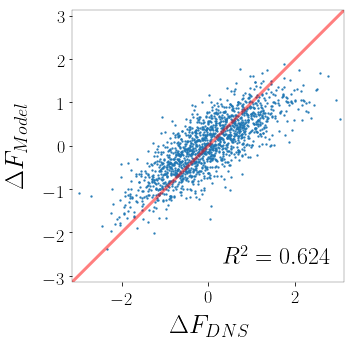

In [66]:
%reset -f
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# load dataset
# dataset = pd.read_csv('../dataset/Re2_phi02', header=None, delim_whitespace=True).values

X_in = dataset[::1, :np.size(dataset,axis=1)-3]
Y_in = dataset[::1, np.size(dataset, axis=1)-3]
Y_in -= np.mean(Y_in)

X_in, x_isolated_test,\
Y_in, y_isolated_test = train_test_split(X_in, Y_in,
                                   test_size=0.5,
                                   shuffle=True,)

beta = 1
num_p_incl = 15
kf = KFold(n_splits=8, shuffle=True)
train_scores = []
test_scores = []

print(X_in.shape)
print(f'# of included particles: {num_p_incl} out of {int((X_in.shape[1]-3) / 3)}')
print('________________________________________')

X_test_plot = np.zeros((0, X_in.shape[1]))
D_test_plot = np.zeros((0))
D_pred_plot = np.zeros((0))

# The cross-validation loop________________________________
for train_index, test_index in kf.split(X_in):
    
    X, X_test = X_in[train_index], X_in[test_index]
    Y, Y_test = Y_in[train_index], Y_in[test_index]
    
    D_in = Y
    
    F_l_2 = -2*np.std(D_in)
    F_l_1 = -1*np.std(D_in)
    F_h_1 = +1*np.std(D_in)
    F_h_2 = +2*np.std(D_in)

    q = -1;
    kde_list = []

    for Z_i in [F_l_2, F_h_2]:
        
        # Constructing KDEs________________________________
        q += 1
        
        condition = abs(D_in - Z_i) < 1.1*abs(Z_i)
#         if q == 0:
#             condition = D_in > +0.5*Z_i
#         else:
#             condition = D_in < -0.5*Z_i

        X1_tmp = np.array([])
        X2_tmp = np.array([])
        X3_tmp = np.array([])

        for p in np.arange(0, num_p_incl):
            X1, X2, X3 = X[:, 3*p], X[:, 3*p+1], X[:, 3*p+2]
            X1_tmp = np.append(X1_tmp, X1[condition])
            X2_tmp = np.append(X2_tmp, X2[condition])
            X3_tmp = np.append(X3_tmp, X3[condition])
            
        data = np.vstack([X1_tmp, X2_tmp, X3_tmp])
        kde_list.append(gaussian_kde(data))
        bw = 1.3 * kde_list[q].scotts_factor()
        kde_list[q].set_bandwidth(bw)
    
    # Constructing input variables____________________________
    F_l = np.zeros((X.shape[0], 0))
    F_h = np.zeros((X.shape[0], 0))
    
    for j in range(0, num_p_incl):     
        F_l = np.append(F_l, kde_list[0]([ X[:, 3*j], X[:, 3*j+1], X[:, 3*j+2] ]).reshape(-1,1), axis=1)
        F_h = np.append(F_h, kde_list[1]([ X[:, 3*j], X[:, 3*j+1], X[:, 3*j+2] ]).reshape(-1,1), axis=1)
    
    V_in = X[:, -3:]
    X_in_reg = np.hstack((F_l, F_h, V_in))
    X_in_reg = preprocessing.scale(X_in_reg)
#     np.savetxt('probab_data', np.hstack((X_in_reg, D_in.reshape(-1,1))))
    
    # Linear model__________________________________________________
    from sklearn.linear_model import LinearRegression, TheilSenRegressor
    from sklearn.neural_network import MLPRegressor
    from sklearn.svm import SVR
    
    reg = LinearRegression()
#     reg = TheilSenRegressor()
#     reg = SVR(gamma='scale', C=1, epsilon=0.2, degree=3)
#     reg = MLPRegressor(hidden_layer_sizes=(10,5), max_iter=2000, learning_rate='adaptive',
#                       activation='relu', validation_fraction=0.2, alpha=0.1)
    
    reg.fit(X_in_reg, D_in)
    D_pred = beta*reg.predict(X_in_reg)
#     reg.coef_
    
    print(f'Training R^2 \t= {r2_score(D_in, D_pred):.3f}')
    train_scores.append(r2_score(D_in, D_pred))
    
    # Testing__________________________________________________
    X = X_test
    D_in = Y_test
    
    F_l = np.zeros((X.shape[0], 0))
    F_h = np.zeros((X.shape[0], 0))
    
    for j in range(0, num_p_incl):
        
        F_l = np.append(F_l, kde_list[0]([ X[:, 3*j], X[:, 3*j+1], X[:, 3*j+2] ]).reshape(-1,1), axis=1)
        F_h = np.append(F_h, kde_list[1]([ X[:, 3*j], X[:, 3*j+1], X[:, 3*j+2] ]).reshape(-1,1), axis=1)

    V_in = X[:, -3:]
    X_in_reg = np.hstack((F_l, F_h, V_in))
    X_in_reg = preprocessing.scale(X_in_reg)
    
    D_pred_test = beta*reg.predict(X_in_reg)
    print(f'Test R^2 \t= {r2_score(D_in, D_pred_test):.3f}\n')
    test_scores.append(r2_score(D_in, D_pred_test))
    
    # dataset for plotting all the tests together
    X_test_plot = np.vstack((X_test_plot, X_test))
    D_test_plot = np.concatenate((D_test_plot, Y_test))
    D_pred_plot = np.concatenate((D_pred_plot, D_pred_test))
    
print(f'Average Training R^2 = {np.mean(train_scores):.3f}\nAverage Test R^2 = {np.mean(test_scores):.3f}')

# Plots__________________________________________________
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 18})
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 26
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['axes.linewidth']= 0.25
plt.rc('text', usetex=True)

# Isolated sample testing__________________________________________________
X = x_isolated_test
D_in = y_isolated_test

F_l = np.zeros((X.shape[0], 0))
F_h = np.zeros((X.shape[0], 0))

for j in range(0, num_p_incl):

    F_l = np.append(F_l, kde_list[0]([ X[:, 3*j], X[:, 3*j+1], X[:, 3*j+2] ]).reshape(-1,1), axis=1)
    F_h = np.append(F_h, kde_list[1]([ X[:, 3*j], X[:, 3*j+1], X[:, 3*j+2] ]).reshape(-1,1), axis=1)

V_in = X[:, -3:]
X_in_reg = np.hstack((F_l, F_h, V_in))
X_in_reg = preprocessing.scale(X_in_reg)

D_pred_isolated_test = beta*reg.predict(X_in_reg)
    
# Entire dataset

D_pred = D_pred_isolated_test

plt.scatter(D_in, D_pred, marker='o', s=2, alpha=0.8);

plt.xlabel('$\Delta F_{DNS}$')
plt.ylabel('$\Delta F_{Model}$')

lim1 = np.mean(D_in) - 3.5*np.std(D_in)
lim2 = np.mean(D_in) + 3.5*np.std(D_in)
lim3 = np.mean(D_pred) - 2*np.std(D_pred)

# generate the best fit for the predicted data:___________________
# reg2 = LinearRegression()
# reg2.fit(D_in.reshape(-1,1), D_pred.reshape(-1,1))
# D_vec = np.linspace(lim1, lim2, 100).reshape(-1,1)
# D_reg2 = reg2.predict(D_vec)
# plt.plot(D_vec, D_reg2, '-k', linewidth=2, alpha=0.1);
# _______________________________________________________________

plt.plot([lim1, lim2], [lim1, lim2], '-r', linewidth=3, alpha=0.5);

plt.gca().set_aspect('equal')
# plt.axis('square')
plt.xlim((1.*lim1, 1.*lim2))
plt.ylim((1.*lim1, 1.*lim2))

x_ann = plt.xlim()[1] - 0.05*(plt.xlim()[1]-plt.xlim()[0])
y_ann = plt.ylim()[0] + 0.05*(plt.ylim()[1]-plt.ylim()[0])
plt.annotate(str(f'$R^2 = {r2_score(D_in, D_pred):.3f}$'), 
             xy=(x_ann, y_ann),
             horizontalalignment='right',
             verticalalignment='bottom',
             fontsize=24);
# fig.savefig('probability_map_drag.pdf', bbox_inches='tight')

## Force map based on MPP model

Number of included neighbors: 10


Text(0, 0.5, '$ \\Delta F_x $')

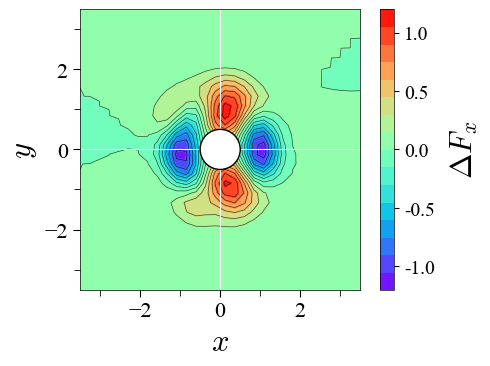

In [536]:
%reset -f array
from matplotlib.patches import Circle

# Load saved model ______________________________
import pickle, dill
with open('reg.sav', 'rb') as f:
    reg = pickle.load(f)
with open('kde_list.sav', 'rb') as f:
    kde_list = dill.load(f)
# _________________________________________

lim = 3.5
mesh = 30j

levels = 20

num_p_incl = (reg.coef_.shape[0] - 3) // 2
print(f'Number of included neighbors: {num_p_incl}')

xx, yy = np.mgrid[-lim:lim:mesh, -lim:lim:mesh]
X1 = np.zeros(3)     # location vec of first neighbor
X2 = np.zeros(3)     # location vec of second neighbor

X2[0], X2[1], X2[2]  = 0, 0, 0

# filling the location of other neighbors by random values ___________________________
X_tmp = np.random.uniform(-4, 4,
                          (1, 3*(num_p_incl-2) + 3)) * np.ones((1 , 3*(num_p_incl-2) + 3))
X = np.hstack((X1.reshape(1,-1), X2.reshape(1,-1), X_tmp)).ravel()

D_pred = np.zeros((xx.shape[0], xx.shape[1]))

for i in range(0, xx.shape[0]):
    for j in range(0, yy.shape[1]):

        X[0] = xx[i, j]
        X[1] = yy[i, j]
        X[2] = 0

        F_l = np.zeros((1, 0))
        F_h = np.zeros((1, 0))

        for p in range(0, num_p_incl):
            F_l = np.append(F_l, kde_list[0]([ X[3*p], X[3*p+1], X[3*p+2] ]).reshape(1,-1), axis=1)
            F_h = np.append(F_h, kde_list[1]([ X[3*p], X[3*p+1], X[3*p+2] ]).reshape(1,-1), axis=1)
        
        V_in = np.array([[0.8, 0, 0]])
#         X_in_reg = np.hstack((F_l, F_h, V_in))

#         D_pred[i, j] = reg.predict(X_in_reg)

#         D_pred[i, j] = np.sum(
#             F_l * reg.coef_[ :(2 * num_p_incl) // 2]) + np.sum(
#             F_h * reg.coef_[(2 * num_p_incl) // 2:-3]) + 0*(np.sum(
#             V_in * reg.coef_[-3:]) + reg.intercept_)
        
        D_pred[i, j] = F_l[0, 0] * (-100) + F_h[0, 0] * 110 + 0*(
            np.sum(V_in * reg.coef_[-3:]) + reg.intercept_)
        
# Plots _________________________________________
fig, ax1 = plt.subplots(figsize=(5,5), tight_layout=True)

contour = ax1.contourf(xx, yy, D_pred,
             cmap='rainbow',
             levels=levels,
             zorder=0)
contour2 = ax1.contour(xx, yy, D_pred,
    linewidths=0.5, linestyles='solid', colors='black', alpha=0.7, levels=levels, zorder=0)

# Reference circle ______________________
circ1 = plt.Circle((0,0), radius=0.5,
                   alpha=1,
                   facecolor='white',
                   edgecolor='black',
                   zorder=3)
ax1.add_patch(circ1)


# Second neighbor circle ______________________
# if X2[2] < 1:
#     circ2 = plt.Circle((X2[0],X2[1]), radius=0.5,
#                    alpha=0.3,
#                    linewidth=2.5,
#                    facecolor='black',
#                    edgecolor='black',
#                    zorder=4)
#     ax1.add_patch(circ2)
#     circ3 = plt.Circle((X2[0], X2[1]), radius=1, alpha=1, facecolor='w', edgecolor='none', zorder=1)
#     ax1.add_patch(circ3)
    
ax1.set_aspect('equal')

ax1.set_xticks(range(-4,5,2))
ax1.set_yticks(range(-4,5,2))

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))
ax1.tick_params(which='major', length=5)
ax1.tick_params(which='minor', length=4)

ax1.set_xlabel('$ x $')
ax1.set_ylabel('$ y $')

ax1.vlines(x=0, ymin=yy.min(), ymax=yy.max(), color='white', linewidth=0.75, zorder=1)
ax1.hlines(y=0, xmin=xx.min(), xmax=xx.max(), color='white', linewidth=0.75, zorder=1)

# Color bar________________________________
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.2)
cb = fig.colorbar(contour, cax=cax, format='%.1f')

from matplotlib.ticker import FormatStrFormatter
cb.ax.tick_params(labelsize=14)

for l in cb.ax.yaxis.get_ticklabels():
    l.set_family('Times New Roman')

# Set the font name for axis tick labels______________
for tick in ax1.get_xticklabels():
    tick.set_fontname('Times New Roman')
for tick in ax1.get_yticklabels():
    tick.set_fontname('Times New Roman')
# remove white lines separating the contours_______________
for c in contour.collections:
    c.set_edgecolor('face')
    
# Adjust number of ticks in colorbar
from matplotlib import ticker
tick_locator = ticker.MaxNLocator(nbins=6)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.set_ylabel('$ \Delta '+ coord + ' $', labelpad=10)

# fig.savefig('map1.pdf', bbox_inches='tight')